In [1]:
import numpy as np
import kmeans
import common
import naive_em
import em

In [2]:
X = np.loadtxt("toy_data.txt")

In [3]:
K = [1,2,3,4]
Seed = [0,1,2,3,4]
cost_matrix = np.zeros((4,5))
cost_matrix

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [5]:
for i in range(0,4):
    for j in range(0,5):
        mixture, post = common.init(X, K=K[i], seed=Seed[j])
        mixture, post, cost = kmeans.run(X, mixture, post)
        cost_matrix[i,j] = cost
np.min(cost_matrix, axis=1)

array([5462.29745234, 1684.9079503 , 1329.59486715, 1035.49982654])

### Naive-em

In [6]:
from typing import Tuple
import numpy as np
from common import GaussianMixture

In [7]:

def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component
    Args:
        X: (n, d) array holding the data
        mixture: the current gaussian mixture
    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """
    n, d = X.shape
    mu, var, pi = mixture  # Unpack mixture tuple
    K = mu.shape[0]
    
    # Compute normal dist. matrix: (N, K)
    pre_exp = (2*np.pi*var)**(d/2)
    
    # Calc exponent term: norm matrix/(2*variance)
    post = np.linalg.norm(X[:,None] - mu, ord=2, axis=2)**2   # Vectorized version
    post = np.exp(-post/(2*var))
    
#    post = np.zeros((n, K), dtype=np.float64) # For loop version: Array to hold posterior probs and normal matrix
#    for i in range(n):  # Use single loop to complete Normal matrix: faster than broadcasting in 3D
#        dist = X[i,:] - mu     # Compute difference: will be (K,d) for each n
#        norm = np.sum(dist**2, axis=1)  # Norm: will be (K,) for each n
#        post[i,:] = np.exp(-norm/(2*var))   # This is the exponent term of normal
    
    post = post/pre_exp     # Final Normal matrix: will be (n, K)

    numerator = post*pi
    denominator = np.sum(numerator, axis=1).reshape(-1,1) # This is the vector p(x;theta)
 
    post = numerator/denominator    # This is the matrix of posterior probs p(j|i)
    
    log_lh = np.sum(np.log(denominator), axis=0).item()    # Log-likelihood
    
    return post, log_lh


In [8]:

def mstep(X: np.ndarray, post: np.ndarray) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset
    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples
    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    K = post.shape[1]
    
    nj = np.sum(post, axis=0)   # shape is (K, )
    
    pi = nj/n   # Cluster probs; shape is (K, )
    
    mu = (post.T @ X)/nj.reshape(-1,1)  # Revised means; shape is (K,d)
    
    norms = np.linalg.norm(X[:, None] - mu, ord=2, axis=2)**2    # Vectorized version

#    norms = np.zeros((n, K), dtype=np.float64) # For loopy version: Matrix to hold all the norms: (n,K)
#    for i in range(n):
#        dist = X[i,:] - mu
#        norms[i,:] = np.sum(dist**2, axis=1)
        
    var = np.sum(post*norms, axis=0)/(nj*d)     # Revised variance; shape is (K, )
    
    return GaussianMixture(mu, var, pi)


In [9]:

def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model
    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples
    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """
    
    old_log_lh = None
    new_log_lh = None  # Keep track of log likelihood to check convergence
    
    # Start the main loop
    while old_log_lh is None or (new_log_lh - old_log_lh > 1e-6*np.abs(new_log_lh)):
        
        old_log_lh = new_log_lh
        
        # E-step
        post, new_log_lh = estep(X, mixture)
        
        # M-step
        mixture = mstep(X, post)
            
    return mixture, post, new_log_lh

### Comparing K-means and em on toy_data.txt

In [10]:
########## Begin: kMeans vs EM (and BIC) #############

K = [1, 2, 3, 4]    # Clusters to try
seeds = [0, 1, 2, 3, 4]     # Seeds to try

# Costs for diff. seeds
costs_kMeans = [0, 0, 0, 0, 0]
costs_EM = [0, 0, 0, 0, 0]

# Best seed for cluster based on lowest costs 
best_seed_kMeans = [0, 0, 0, 0]
best_seed_EM = [0, 0, 0, 0]

# Mixtures for best seeds
mixtures_kMeans = [0, 0, 0, 0, 0]
mixtures_EM = [0, 0, 0, 0, 0]

# Posterior probs. for best seeds
posts_kMeans = [0, 0, 0, 0, 0]
posts_EM = [0, 0, 0, 0, 0]

# BIC score of cluster
bic = [0., 0., 0., 0.]


=============== Clusters: 1 ======================
Lowest cost using kMeans is: 5462.297452340001
Highest log likelihood using EM is: -1307.2234317600935


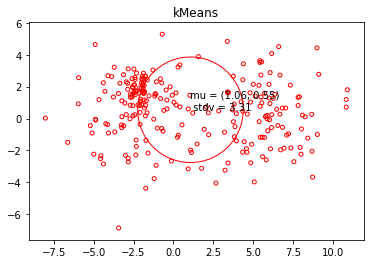

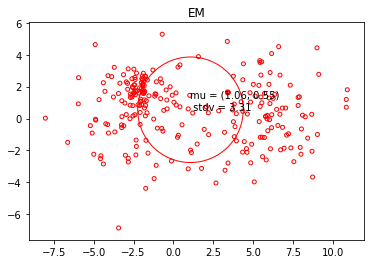

=============== Clusters: 2 ======================
Lowest cost using kMeans is: 1684.9079502962372
Highest log likelihood using EM is: -1175.7146293666797


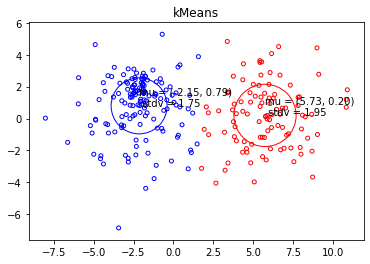

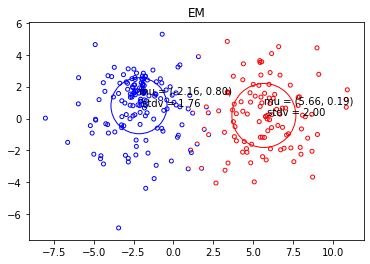

=============== Clusters: 3 ======================
Lowest cost using kMeans is: 1329.5948671544297
Highest log likelihood using EM is: -1138.8908996872672


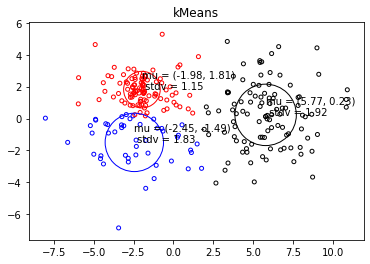

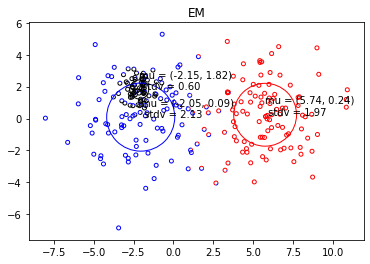

=============== Clusters: 4 ======================
Lowest cost using kMeans is: 1035.4998265394659
Highest log likelihood using EM is: -1138.6011756994849


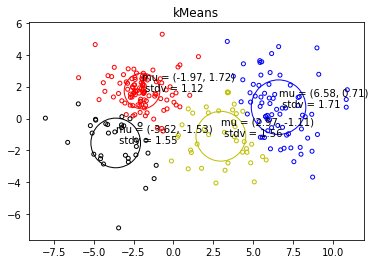

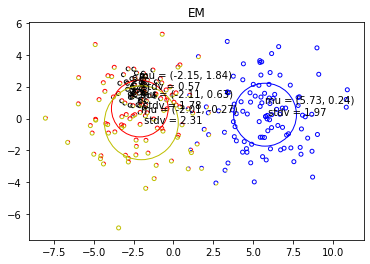

================= BIC ====================
Best K is: 3
BIC for the best K is: -1169.2589347355095


In [11]:

for k in range(len(K)):
    for i in range(len(seeds)):
        
        # Run kMeans
        mixtures_kMeans[i], posts_kMeans[i], costs_kMeans[i] = \
        kmeans.run(X, *common.init(X, K[k], seeds[i]))
        
        # Run Naive EM
        mixtures_EM[i], posts_EM[i], costs_EM[i] = \
        naive_em.run(X, *common.init(X, K[k], seeds[i]))
    
    # Print lowest cost
    print("=============== Clusters:", k+1, "======================")
    print("Lowest cost using kMeans is:", np.min(costs_kMeans))
    print("Highest log likelihood using EM is:", np.max(costs_EM))
    
    # Save best seed for plotting
    best_seed_kMeans[k] = np.argmin(costs_kMeans)
    best_seed_EM[k] = np.argmax(costs_EM) 
    
    # Plot kMeans and EM results
    common.plot(X, 
                mixtures_kMeans[best_seed_kMeans[k]], 
                posts_kMeans[best_seed_kMeans[k]], 
                title="kMeans")

    common.plot(X, 
                mixtures_EM[best_seed_EM[k]], 
                posts_EM[best_seed_EM[k]], 
                title="EM") 
    
    #BIC score for EM
    bic[k] = common.bic(X, mixtures_EM[best_seed_EM[k]], np.max(costs_EM))
    
# Print the best K based on BIC
print("================= BIC ====================")
print("Best K is:", np.argmax(bic)+1)
print("BIC for the best K is:", np.max(bic))
 
########## End: kMeans vs EM (and BIC) ###########

=============== Clusters: 1 ======================
Lowest cost using kMeans is: 5462.297452340001
Highest log likelihood using EM is: -1307.2234317600935


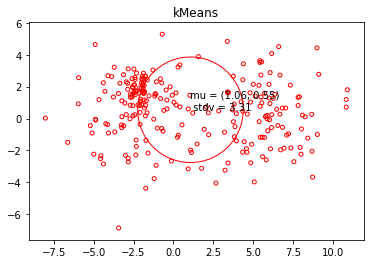

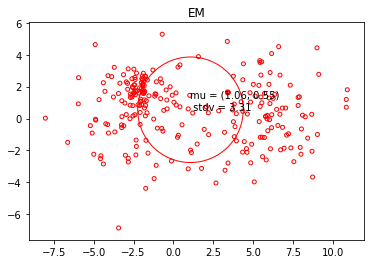

=============== Clusters: 2 ======================
Lowest cost using kMeans is: 1684.9079502962372
Highest log likelihood using EM is: -1175.7146293666797


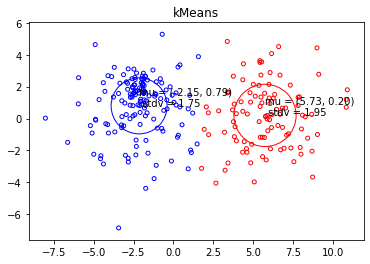

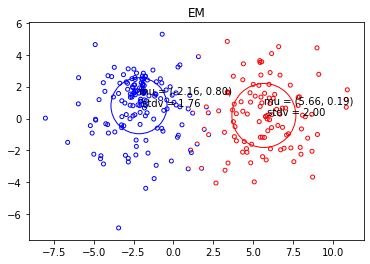

=============== Clusters: 3 ======================
Lowest cost using kMeans is: 1329.5948671544297
Highest log likelihood using EM is: -1138.8908996872672


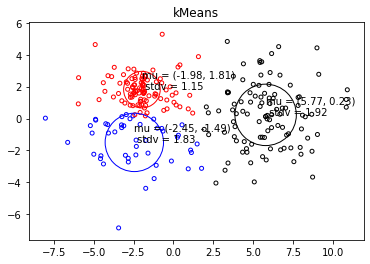

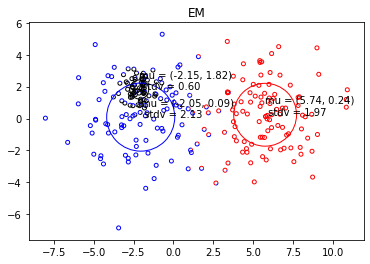

=============== Clusters: 4 ======================
Lowest cost using kMeans is: 1035.4998265394659
Highest log likelihood using EM is: -1138.6011756994849


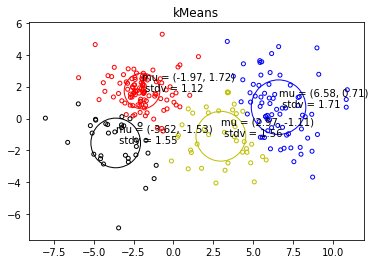

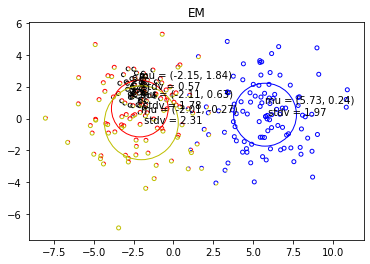

================= BIC ====================
Best K is: 3
BIC for the best K is: -1169.2589347355095


In [12]:

for k in range(len(K)):
    for i in range(len(seeds)):
        
        # Run kMeans
        mixtures_kMeans[i], posts_kMeans[i], costs_kMeans[i] = \
        kmeans.run(X, *common.init(X, K[k], seeds[i]))
        
        # Run Naive EM
        mixtures_EM[i], posts_EM[i], costs_EM[i] = \
        naive_em.run(X, *common.init(X, K[k], seeds[i]))
    
    # Print lowest cost
    print("=============== Clusters:", k+1, "======================")
    print("Lowest cost using kMeans is:", np.min(costs_kMeans))
    print("Highest log likelihood using EM is:", np.max(costs_EM))
    
    # Save best seed for plotting
    best_seed_kMeans[k] = np.argmin(costs_kMeans)
    best_seed_EM[k] = np.argmax(costs_EM) 
    
    # Plot kMeans and EM results
    common.plot(X, 
                mixtures_kMeans[best_seed_kMeans[k]], 
                posts_kMeans[best_seed_kMeans[k]], 
                title="kMeans")

    common.plot(X, 
                mixtures_EM[best_seed_EM[k]], 
                posts_EM[best_seed_EM[k]], 
                title="EM") 
    
    #BIC score for EM
    bic[k] = common.bic(X, mixtures_EM[best_seed_EM[k]], np.max(costs_EM))
    
# Print the best K based on BIC
print("================= BIC ====================")
print("Best K is:", np.argmax(bic)+1)
print("BIC for the best K is:", np.max(bic))
 
########## End: kMeans vs EM (and BIC) ###########


### em

In [13]:
from typing import Tuple
import numpy as np
from scipy.special import logsumexp
from common import GaussianMixture

In [14]:
def estep(X: np.ndarray, mixture: GaussianMixture) -> Tuple[np.ndarray, float]:
    """E-step: Softly assigns each datapoint to a gaussian component
    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        mixture: the current gaussian mixture
    Returns:
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the assignment
    """
    n, d = X.shape
    mu, var, pi = mixture   # Unpack mixture tuple
    K = mu.shape[0]
    
######## Vectorized version to calculate norms ########
    
    # Create a delta matrix to indicate where X is non-zero, which will help us pick Cu indices
    delta = X.astype(bool).astype(int)
    # Exponent term: norm matrix/(2*variance)
#    f = np.sum(((X[:, None, :] - mu)*delta[:, None, :])**2, axis=2)/(2*var) # This is using 3D broadcasting: slowest of all
    f = (np.sum(X**2, axis=1)[:,None] + (delta @ mu.T**2) - 2*(X @ mu.T))/(2*var) # This is using indicator matrix: fastest of all
    # Pre-exponent term: A matrix of shape (n, K)
    pre_exp = (-np.sum(delta, axis=1).reshape(-1,1)/2.0) @ (np.log((2*np.pi*var)).reshape(-1,1)).T
    # Put them together
    f = pre_exp - f
    
######## End: vectorized version ########
    
    f = f + np.log(pi + 1e-16)  # This is the f(u,j) matrix
    
    # log of normalizing term in p(j|u)
    logsums = logsumexp(f, axis=1).reshape(-1,1)  # Store this to calculate log_lh
    log_posts = f - logsums # This is the log of posterior prob. matrix: log(p(j|u))
    
    log_l = np.sum(logsums, axis=0).item()   # This is the log likelihood
    
    return np.exp(log_posts), log_l

In [15]:
def mstep(X: np.ndarray, post: np.ndarray, mixture: GaussianMixture,
          min_variance: float = .25) -> GaussianMixture:
    """M-step: Updates the gaussian mixture by maximizing the log-likelihood
    of the weighted dataset
    Args:
        X: (n, d) array holding the data, with incomplete entries (set to 0)
        post: (n, K) array holding the soft counts
            for all components for all examples
        mixture: the current gaussian mixture
        min_variance: the minimum variance for each gaussian
    Returns:
        GaussianMixture: the new gaussian mixture
    """
    n, d = X.shape
    mu_rev, _, _ = mixture
    K = mu_rev.shape[0]
    
    # Calculate revised pi(j): same expression as in the naive case
    pi_rev = np.sum(post, axis=0)/n
    
    # Create delta matrix indicating where X is non-zero
    delta = X.astype(bool).astype(int)
    
    # Update means only when sum_u(p(j|u)*delta(l,Cu)) >= 1
    denom = post.T @ delta # Denominator (K,d): Only include dims that have information
    numer = post.T @ X  # Numerator (K,d)
    update_indices = np.where(denom >= 1)   # Indices for update
    mu_rev[update_indices] = numer[update_indices]/denom[update_indices] # Only update where necessary (denom>=1)
    
    # Update variances
    denom_var = np.sum(post*np.sum(delta, axis=1).reshape(-1,1), axis=0) # Shape: (K,)
    
######## Loop version for norms calc. ##########
    
    # Norm matrix for variance calc
#    norms = np.zeros((n, K), dtype=np.float64)
#    
#    for i in range(n):
#        # For each user pick only columns that have ratings
#        Cu_indices = X[i,:] != 0
#        diff = X[i, Cu_indices] - mu_rev[:, Cu_indices]    # This will be (K,|Cu|)
#        norms[i,:] = np.sum(diff**2, axis=1)  # This will be (K,)
    
######## End: loop version #########
        
######## Vectorized version for norms calc. ########
    
#    norms = np.sum(((X[:, None, :] - mu_rev)*delta[:, None, :])**2, axis=2)
    norms = np.sum(X**2, axis=1)[:,None] + (delta @ mu_rev.T**2) - 2*(X @ mu_rev.T)
    
######## End: vectorized version #########
    
    # Revised var: if var(j) < 0.25, set it = 0.25
    var_rev = np.maximum(np.sum(post*norms, axis=0)/denom_var, min_variance)  
    
    return GaussianMixture(mu_rev, var_rev, pi_rev)

In [16]:
def run(X: np.ndarray, mixture: GaussianMixture,
        post: np.ndarray) -> Tuple[GaussianMixture, np.ndarray, float]:
    """Runs the mixture model
    Args:
        X: (n, d) array holding the data
        post: (n, K) array holding the soft counts
            for all components for all examples
    Returns:
        GaussianMixture: the new gaussian mixture
        np.ndarray: (n, K) array holding the soft counts
            for all components for all examples
        float: log-likelihood of the current assignment
    """
    old_log_lh = None
    new_log_lh = None  # Keep track of log likelihood to check convergence
    
    # Start the main loop
    while old_log_lh is None or (new_log_lh - old_log_lh > 1e-6*np.abs(new_log_lh)):
        
        old_log_lh = new_log_lh
        
        # E-step
        post, new_log_lh = estep(X, mixture)
        
        # M-step
        mixture = mstep(X, post, mixture)
            
    return mixture, post, new_log_lh

## run em algo on netflix incomplete.txt

In [17]:
K = [1, 12]    # Clusters to try
seeds = [0, 1, 2, 3, 4]     # Seeds to try

# Costs for diff. seeds
costs_kMeans = [0, 0, 0, 0, 0]
costs_EM = [0, 0, 0, 0, 0]

# Best seed for cluster based on lowest costs 
best_seed_kMeans = [0, 0, 0, 0]
best_seed_EM = [0, 0, 0, 0]

# Mixtures for best seeds
mixtures_kMeans = [0, 0, 0, 0, 0]
mixtures_EM = [0, 0, 0, 0, 0]

# Posterior probs. for best seeds
posts_kMeans = [0, 0, 0, 0, 0]
posts_EM = [0, 0, 0, 0, 0]

# BIC score of cluster
bic = [0., 0., 0., 0.]

In [18]:
for k in range(len(K)):
    for i in range(len(seeds)):
        
        # Run kMeans
        mixtures_kMeans[i], posts_kMeans[i], costs_kMeans[i] = \
        kmeans.run(X, *common.init(X, K[k], seeds[i]))
        
        # Run EM
        mixtures_EM[i], posts_EM[i], costs_EM[i] = \
        em.run(X, *common.init(X, K[k], seeds[i]))
    
    # Print lowest cost
    print("=============== Clusters:", k+1, "======================")
    print("Lowest cost using kMeans is:", np.min(costs_kMeans))
    print("Highest log likelihood using EM is:", np.max(costs_EM))
    
    # Save best seed for plotting
    best_seed_kMeans[k] = np.argmin(costs_kMeans)
    best_seed_EM[k] = np.argmax(costs_EM) 
    
    
    #BIC score for EM
    bic[k] = common.bic(X, mixtures_EM[best_seed_EM[k]], np.max(costs_EM))
    
# Print the best K based on BIC
print("================= BIC ====================")
print("Best K is:", np.argmax(bic)+1)
print("BIC for the best K is:", np.max(bic))
 
########## End: kMeans vs EM (and BIC) ###########

=============== Clusters: 1 ======================
Lowest cost using kMeans is: 5462.297452340001
Highest log likelihood using EM is: -1307.2234317600935
=============== Clusters: 2 ======================
Lowest cost using kMeans is: 396.7351463045391
Highest log likelihood using EM is: -1118.6190434326677
================= BIC ====================
Best K is: 3
BIC for the best K is: 0.0


### Testing on Complete

In [31]:
import em
import test

In [32]:
K = [1, 12]    # Clusters to try
seeds = [0, 1, 2, 3, 4]     # Seeds to try

# Costs for diff. seeds
costs_kMeans = [0, 0, 0, 0, 0]
costs_EM = [0, 0, 0, 0, 0]

# Best seed for cluster based on lowest costs 
best_seed_kMeans = [0, 0, 0, 0]
best_seed_EM = [0, 0, 0, 0]

# Mixtures for best seeds
mixtures_kMeans = [0, 0, 0, 0, 0]
mixtures_EM = [0, 0, 0, 0, 0]

# Posterior probs. for best seeds
posts_kMeans = [0, 0, 0, 0, 0]
posts_EM = [0, 0, 0, 0, 0]

# BIC score of cluster
bic = [0., 0., 0., 0.]

In [33]:
for k in range(len(K)):
    for i in range(len(seeds)):
        
        # Run kMeans
        mixtures_kMeans[i], posts_kMeans[i], costs_kMeans[i] = \
        kmeans.run(X, *common.init(X, K[k], seeds[i]))
        
        # Run EM
        mixtures_EM[i], posts_EM[i], costs_EM[i] = \
        em.run(X, *common.init(X, K[k], seeds[i]))
    
    # Print lowest cost
    print("=============== Clusters:", k+1, "======================")
    print("Lowest cost using kMeans is:", np.min(costs_kMeans))
    print("Highest log likelihood using EM is:", np.max(costs_EM))
    #print(fill_matrix(X, mixture))
    print(fill_matrix(np.ndarray, GaussianMixture)
    
    # Save best seed for plotting
    best_seed_kMeans[k] = np.argmin(costs_kMeans)
          
    best_seed_EM[k] = np.argmax(costs_EM) 
    
    
    #BIC score for EM
    bic[k] = common.bic(X, mixtures_EM[best_seed_EM[k]], np.max(costs_EM))
    
# Print the best K based on BIC
print("================= BIC ====================")
print("Best K is:", np.argmax(bic)+1)
print("BIC for the best K is:", np.max(bic))
 
########## End: kMeans vs EM (and BIC) ###########

SyntaxError: invalid syntax (Temp/ipykernel_27424/177755512.py, line 20)